In [1]:
import mujoco
import mediapy as media
import numpy as np
import casadi as cs

from robot_descriptions.loaders.mujoco import load_robot_description
from darli.robots import manipulator
from darli.modeling import Robot
from darli.backend import PinocchioBackend

%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


Barrier function: \
Existence of $h(x)$ implies invariance of safety level sets. (Nagumo)
$$\dot x = f (x)$$
$$\mathcal{C} =  \{x|h(x)>0\}\\
\dot h > 0 \forall x \in \partial{\mathcal{C}}$$

# Control Barrier Functions



Barrier functions are used to prove safety of nonlinear and hybrid systems [[1]](https://arxiv.org/abs/1903.11199). The name "barrier" appears in the optimization literature due to the fact that barrier functions are added to the cost function to avoid undesirable regions [[1]](https://arxiv.org/abs/1903.11199).

Definition using Nagumo theorem [[2]](https://www.youtube.com/watch?v=3HXIo_HaPRc):
$$\dot x = f (x) + g(x) u$$
$$\mathcal{C} = \{x|h(x)>0\} \text{ (the set is invariant)}\\
\exist u \text{ }s.t. \text{ } \dot h \geq 0 \text{ }  \forall x \in \partial{\mathcal{C}} \text{ (on the boundary)}$$
$B(x) = - h(x)$ is a Barrier certificate function: $B(x) \leq 0 \text{ } \forall x \in \mathcal{C}_0$ and $\dot B(x) \leq 0 \text { } \forall x \in \mathcal{C}_u$ - unsafe set (complement to the safe set $\mathcal{C} = \mathcal{C}_u^{c}$).

![alt text](figs/CBF_def.png "CBF definition")
![alt text](figs/CBF_def1.png "CBF definition")


But for the CBF we need more smooth version of the function, that is the motivation for extension 
Therefore we use the exponential form of the CBF to apply convergence rate for safety function:

The set of all control values that render $\mathcal{C}$ safe:$L_f h(x) + L_g h(x) u + \alpha(h(x)) \geq 0 $

<font size="1">

**_Invariant set:_** Suppose ${\displaystyle {\dot {x}}=f(x)}$ is a dynamical system, 
${\displaystyle x(t,x_{0})}$ is a trajectory, and 
${\displaystyle x_{0}}$ is the initial point. Let 
${\displaystyle {\mathcal {O}}:=\left\lbrace x\in \mathbb {R} ^{n}\mid \varphi (x)=0\right\rbrace }$ where ${\displaystyle \varphi }$ is a real-valued function. The set 
${\displaystyle {\mathcal {O}}}$ is said to be positively invariant if 
${\displaystyle x_{0}\in {\mathcal {O}}}$ implies that 
$\displaystyle x(t,x_{0})\in \mathcal {O}\ \forall \ t\geq 0$
once a trajectory of the system enters $\mathcal {O}$, it will never leave it again.
</font>



Load the robot kinematics from urdf file.

In [2]:
urdf_file = 'z1/z1.urdf'
model = manipulator(Robot, PinocchioBackend, urdf_path=urdf_file, ee={"ee": "link06"})

Define number of states variables for robot position, velocity and control input

In [3]:
nq, nv, nu = model.nq, model.nv, model.nu
n_task = 3
dt_route = 1e-3
t_end = 20

In [4]:
mj_model = mujoco.MjModel.from_xml_path("z1/scene.xml")
data = mujoco.MjData(mj_model)
mj_model.opt.timestep = dt_route

renderer = mujoco.Renderer(mj_model)
scene_option = mujoco.MjvOption()

# System dynamics:
$M(q)\ddot q + h = u$


$\dot s = \underbrace{\begin{bmatrix} v \\ \frac{ - h }{M(q)} \end{bmatrix}}_{f(s)}  + \underbrace{\begin{bmatrix} 0 \\  \frac{1}{M(q)}\end{bmatrix}}_{g(s)} u $

# Desired Trajectory
Lets define the desired trajectory as a barrier function.
$$
\begin{matrix}
tr = \begin{bmatrix}
 0 \\
 r \sin(t) \\
 r \cos(t)
\end{bmatrix}
&
\dot{tr} = \begin{bmatrix}
 0 \\
 r \cos(t) \\
  -r \sin(t)
\end{bmatrix}
&
\ddot {tr} = \begin{bmatrix}
 0 \\
 -r \sin(t) \\
  -r \cos(t)
\end{bmatrix}
&
\end{matrix}$$

$\varphi (q) = f_{kin} - tr$

$\frac{d \varphi}{dt} = \dot f_{kin} - \dot {tr} = \frac{\partial f_{kin}}{\partial q} v - \dot {tr}$

$\frac{d^2 \varphi}{dt^2} = \frac{\partial f_{kin}}{\partial q} \dot v + \frac{d}{dt}(\frac{\partial f_{kin}}{\partial q})v - \ddot {tr}$


# Input constraints:
$$u_{min}<u<u_{max}$$

# Stability objective:
$$x \rightarrow tr$$

For the numerical approximation I will use Shooting technique (use numerical integrator for each $t_k$).

The **stability objective** will be used in the cost function in a form of minimal effort problem:
So, the cost function $cost_{tr} =  ||K_p \varphi (q) + K_d \dot \varphi(q)||$

# Safety objective:
$$v < v_{max}$$
Then intuitive choice for CBF — $h(x) =  (v_{max} - v)^2$

$\nabla h(x) = \begin{bmatrix} 0 \\ 2 (v - v_{max})\end{bmatrix}$

The safety objective will be placed in the constraints.


Constraint $\dot h(x, u) + \gamma h(x) = L_f h(x) + L_g h(x) u + \alpha(h(x)) = (v_{max} - v)\frac{h - u}{M(q)} + \gamma h(x)\geq 0$,
$\gamma > 0$.

$\dot h(x, u) + \gamma h(x) = $

Lets apply maximum control input $u = u_{max}$:

$\dot B(x, u) + \gamma B(x) = \frac{C(q, v) + h - u_{max}}{M(q)} + \gamma(v_{max} - v) \geq 0$


<!-- $\dot B(x) = |C(q, v) + h| + u_{max}$ -->


<!-- $$
B = \frac{1}{2}q^T M(q) q \\
\dot B = q^T M(q) \dot q + \frac{1}{2} q^T \dot M q \underbrace{=-q^T h}_{\text{substitute from dynamics}} > 0\\
$$ -->

In [5]:
def trajectory(t, r=1, q_0=np.array([0, 0, 0]), period_multiplier:float = 0.1):
    return q_0 + np.array([r * np.sin(period_multiplier*t), r * np.cos(period_multiplier*t), 0])

In [6]:
def trajectory_dt(t, r=1, period_multiplier = 0.1):
    return np.array([period_multiplier *period_multiplier * r * np.cos(period_multiplier* t), -period_multiplier * r * np.sin(period_multiplier* t), 0])

In [7]:
def trajectory_ddt(t, r=1, period_multiplier = 0.1):
    return np.array([-period_multiplier *period_multiplier *r * np.sin(period_multiplier* t), -period_multiplier *period_multiplier * r * np.cos(period_multiplier* t), 0])

In [8]:
def safety(t, v_0, v_max):
    return v_max - v_0

def safety_dt(t, v_0, v_max):
    return - 1

In [9]:
import cvxpy as cp

v_var = cp.Variable(nv, "v_var")
v_dot = cp.Variable(nv, "v_dot")
u = cp.Variable(nu, "u")

In [10]:
J_traj = cp.Parameter((n_task, nv), "J_traj")
b_traj = cp.Parameter((n_task), "b_traj")

u_min = cp.Parameter((nu), "u_min")
u_max = cp.Parameter((nu), "u_max")

v_dot_min = cp.Parameter((nv), "v_dot_min")
v_dot_max = cp.Parameter((nv), "v_dot_max")

v_max = cp.Parameter((nv), "v_max")

In [11]:
M = cp.Parameter((nv, nv), "M")
h = cp.Parameter((nv), "h")
B = cp.Parameter((nv, nu), "B")

# \min 

In [12]:
cost= cp.sum_squares((J_traj@v_dot) + b_traj)
# barrier = cp.max(v_max - v_var)
constraints = [u_min <= u, u <= u_max, v_dot_min <= v_dot, v_dot <= v_dot_max, M@v_dot + h == B@u, (h - u_max)/M + (v_max - v_var)>=0] #, v_var <= v_max ]

In [13]:
objective = cp.Minimize(cost)
problem = cp.Problem(objective, constraints)

In [14]:
start_position = model.body('ee').position
start_position

array([-0.0128,  0.    ,  0.1605])

In [15]:
duration = t_end  # (seconds)
framerate = 30  # used just for visualization

# Simulate and display video.
frames = []
mujoco.mj_resetData(mj_model, data)  # Reset state and time.
ts = []
Kp, Kd = 100, 10
circle_r = 0.1
state_history = []
control_history = []
task_history = []
error_history = []

dt_control = 1e-2
t_next = dt_control

u_min_val = -4 * np.ones(nu)
u_max_val = 4 * np.ones(nu)

v_dot_min_val = -10 * np.ones(nv)
v_dot_max_val = 10 * np.ones(nv)

v_max_val = 0.2 * np.ones(nv)

# z_pos = model.bodies["ee"].jacobian.world_aligned @ trajectory(0, circle_r)
z_pos = np.zeros(nv)
traj_frequency = 0.1

data.qpos = z_pos

while data.time < duration:
    q, v = (
        data.qpos.copy(),
        data.qvel.copy(),
    )
    state = np.hstack((q, v))

    model.update(q, v)
    pos = model.bodies["ee"].position
    jac_curr = model.bodies["ee"].jacobian.world_aligned
    jac_dt_curr = model.bodies["ee"].jacobian_dt.world_aligned

    M_curr = model.inertia(q)
    h_curr = model.coriolis(q, v) + model.gravity(q)

    traj_ddt_curr = trajectory_ddt(data.time, circle_r, traj_frequency)
    traj_dt_curr = trajectory_dt(data.time, circle_r, traj_frequency)
    traj_curr = trajectory(data.time, circle_r, np.array([0, 0.0, 0.2]), traj_frequency)
    v_var.value = v
    J_traj.value = jac_curr[:3]

    b_traj.value = (
        # (jac_dt_curr @ v)[:3]
        # - traj_ddt_curr
        + Kd * ((jac_curr @ v)[:3] - traj_dt_curr)
        + Kp * (pos - traj_curr)
    )

    u_min.value = u_min_val
    u_max.value = u_max_val

    v_dot_min.value = v_dot_min_val
    v_dot_max.value = v_dot_max_val

    v_max.value = v_max_val
    
    M.value = np.array(M_curr)
    h.value = np.array(h_curr)

    B.value = np.eye(nu)

    problem.solve()

    data.ctrl = np.array(u.value)  # .reshape(mj_model.nu, )
    state_history.append(pos.copy())
    task_history.append(traj_curr)
    error_history.append(pos - traj_curr)
    ts.append(data.time)
    control_history.append(data.ctrl.copy())

    mujoco.mj_step(mj_model, data)

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

In [16]:
media.write_video("output.mp4", frames, fps=framerate)

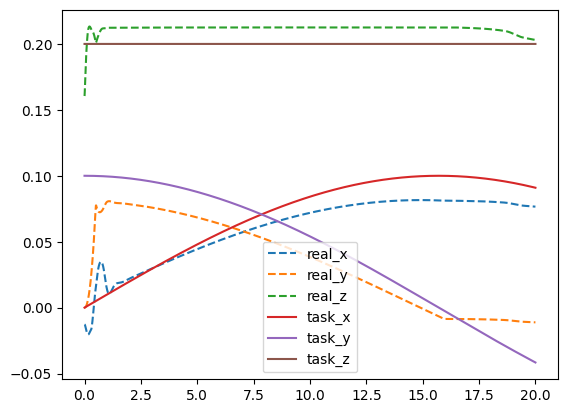

In [17]:
import matplotlib.pyplot as plt

state_history = np.array(state_history)
task_history = np.array(task_history)

# cut_idx = len(state_history) // 2
cut_idx = 0

plt.plot(ts[cut_idx:], state_history[cut_idx:], '--', label=["real_x", "real_y", "real_z"])
plt.plot(ts[cut_idx:], task_history[cut_idx:], label=["task_x", "task_y", "task_z"])
plt.legend()
plt.show()

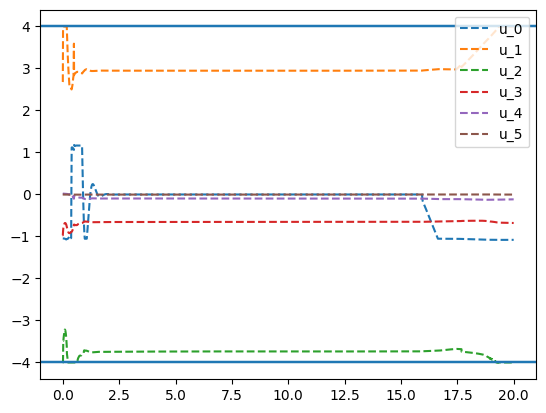

In [18]:
import matplotlib.pyplot as plt

control_history = np.array(control_history)

cut_idx = 0

plt.plot(ts[cut_idx:], control_history[cut_idx:], '--', label=[f"u_{i}" for i in range(len(control_history[0]))])
for i, u_min_ in enumerate(u_max_val):
    plt.axhline(u_min_val[i], 0, 20)
    plt.axhline(u_max_val[i], 0, 20)

plt.legend()
plt.show()

In [19]:
np.array(ts).shape, np.array(error_history).shape

((20000,), (20000, 3))

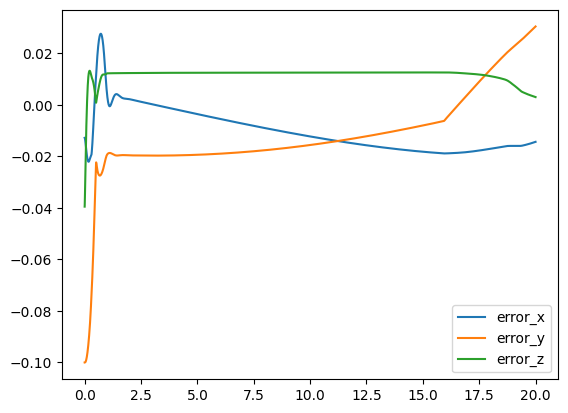

In [20]:
cut_idx = 0
error_history = np.array(error_history)

plt.plot(ts[cut_idx:], error_history[cut_idx:], label=["error_x", "error_y", "error_z"])
plt.legend()
plt.show()